In [1]:
from pathlib import Path
import random

import tensorflow as tf
from tensorflow.data import Dataset
import keras
import numpy as np
import matplotlib.pyplot as plt

from mapping import create_readable_mask
from unet import UnetModel

2023-06-29 01:13:04.180789: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 01:13:04.640079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Dataset preparation

In [2]:
DATASET_PATH='../data'
MODEL_PATH='trained_models/unet.h5'
IMAGE_TRAIN_SIZE=128
IMAGE_TEST_SIZE=256

In [3]:
def dataset_generator(root_path=DATASET_PATH):
    root_path = Path(root_path)
    mc_paths = list(root_path.glob('*/minecraft/*.png'))
    random.shuffle(mc_paths)
    
    for mc_path in mc_paths:
        mask_path = mc_path.parent.parent / 'masks' / mc_path.name
        
        mc_img = tf.io.read_file(str(mc_path))
        mask_img = tf.io.read_file(str(mask_path))
        
        mc_img = tf.image.decode_image(mc_img, channels=3)
        mask_img = tf.image.decode_image(mask_img, channels=1)
        
        yield mc_img, mask_img

In [4]:
dataset = Dataset.from_generator(
    dataset_generator,
    output_types=(tf.uint8, tf.uint8),
    output_shapes=((256, 256, 3), (256, 256, 1))
)

2023-06-29 01:13:05.462155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-29 01:13:05.477421: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-29 01:13:05.477559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
test_dataset = dataset.take(500)
train_dataset = dataset.skip(500)

In [6]:
def resize_train(input_image, input_mask):
    input_image = tf.image.resize(input_image, (IMAGE_TRAIN_SIZE, IMAGE_TRAIN_SIZE), method="nearest")
    input_mask = tf.image.resize(input_mask, (IMAGE_TRAIN_SIZE, IMAGE_TRAIN_SIZE), method="nearest")
    return input_image, input_mask

In [7]:
def resize(input_image, input_mask, size):
    input_image = tf.image.resize(input_image, (size, size), method="nearest")
    input_mask = tf.image.resize(input_mask, (size, size), method="nearest")
    return input_image, input_mask

In [8]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

In [9]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [10]:
def load_image_train(input_image, input_mask):
    input_image, input_mask = resize(input_image, input_mask, IMAGE_TRAIN_SIZE)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [11]:
def load_image_test(input_image, input_mask):
    input_image, input_mask = resize(input_image, input_mask, IMAGE_TEST_SIZE)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [12]:
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = 3_000

In [14]:
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_batches = test_dataset.batch(BATCH_SIZE)

# Visualization

In [15]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  plt.subplot(1, len(display_list), 1)
  plt.title("Input Image")
  plt.imshow(keras.utils.array_to_img(display_list[0]))
  plt.axis("off")

  plt.subplot(1, len(display_list), 2)
  plt.title("True Mask")
  readable_mask = create_readable_mask(display_list[1].numpy().astype(np.uint8)[..., 0])
  plt.imshow(readable_mask)
  plt.axis("off")
  
  if len(display_list) >= 3:
    plt.subplot(1, len(display_list), 3)
    plt.title("Predicted Mask")
    readable_mask = create_readable_mask(display_list[2].numpy().astype(np.uint8)[..., 0])
    plt.imshow(readable_mask)
    plt.axis("off")
    
  plt.show()

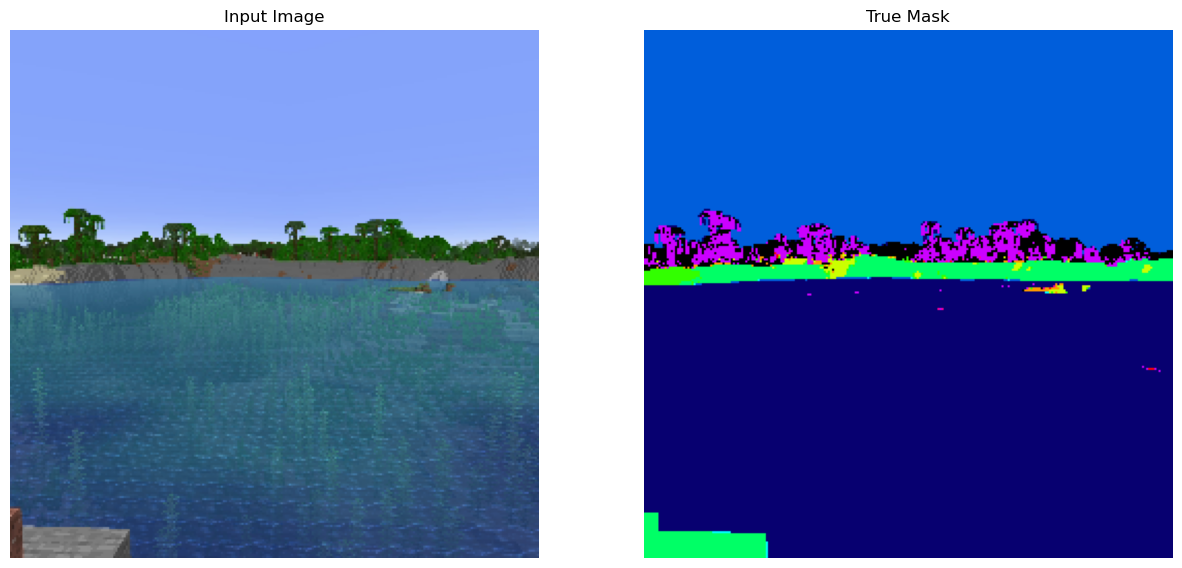

In [20]:
sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

## Model creation 

In [16]:
model = UnetModel()

In [17]:
model.load_weights(MODEL_PATH)

In [23]:
model.summary()

Model: "unet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 downsample_layer (Downsampl  multiple                 38720     
 eLayer)                                                         
                                                                 
 downsample_layer_1 (Downsam  multiple                 221440    
 pleLayer)                                                       
                                                                 
 downsample_layer_2 (Downsam  multiple                 885248    
 pleLayer)                                                       
                                                                 
 downsample_layer_3 (Downsam  multiple                 3539968   
 pleLayer)                                                       
                                                                 
 double_conv_layer_4 (Double  multiple                 1415782

## Training

In [35]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics="accuracy"
)

In [24]:
history = model.fit(
    train_batches,
    epochs=5,
    validation_data=test_batches
)

Epoch 1/5


2023-06-29 00:32:14.128406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-29 00:32:14.128696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-29 00:32:15.510021: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inunet/downsample_layer/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-29 00:32:23.109567: I tensorflow/compiler/xla/stream_executor/c

    154/Unknown - 158s 764ms/step - loss: 0.7840 - accuracy: 0.7509

2023-06-29 00:34:54.068698: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-29 00:34:55.469814: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


    155/Unknown - 173s 860ms/step - loss: 0.7827 - accuracy: 0.7513

2023-06-29 00:35:07.527877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


155/155 [==============================] - 179s 899ms/step - loss: 0.7827 - accuracy: 0.7513 - val_loss: 0.4680 - val_accuracy: 0.8592
Epoch 2/5
155/155 [==============================] - 102s 655ms/step - loss: 0.4067 - accuracy: 0.8752 - val_loss: 0.5710 - val_accuracy: 0.8371
Epoch 3/5
155/155 [==============================] - 94s 609ms/step - loss: 0.3707 - accuracy: 0.8840 - val_loss: 0.3451 - val_accuracy: 0.8874
Epoch 4/5
155/155 [==============================] - 99s 637ms/step - loss: 0.3621 - accuracy: 0.8855 - val_loss: 0.4980 - val_accuracy: 0.8529
Epoch 5/5
155/155 [==============================] - 93s 601ms/step - loss: 0.3984 - accuracy: 0.8781 - val_loss: 0.3601 - val_accuracy: 0.8840


## Learning curve

In [18]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(len(acc))

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

In [ ]:
display_learning_curves(model.history)

## Predictions

In [18]:
def show_predictions(dataset=None, num=1):
    for image, mask in dataset.take(num):
        pred_mask = tf.cast(model.segment(image), tf.uint8)
        display([image[0], mask[0], pred_mask[0]])
        return mask[0].numpy(), pred_mask.numpy()


2023-06-29 01:13:16.938086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-29 01:13:18.327030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-06-29 01:13:18.699036: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-29 01:13:28.558674: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-29 01:13:29.960169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will

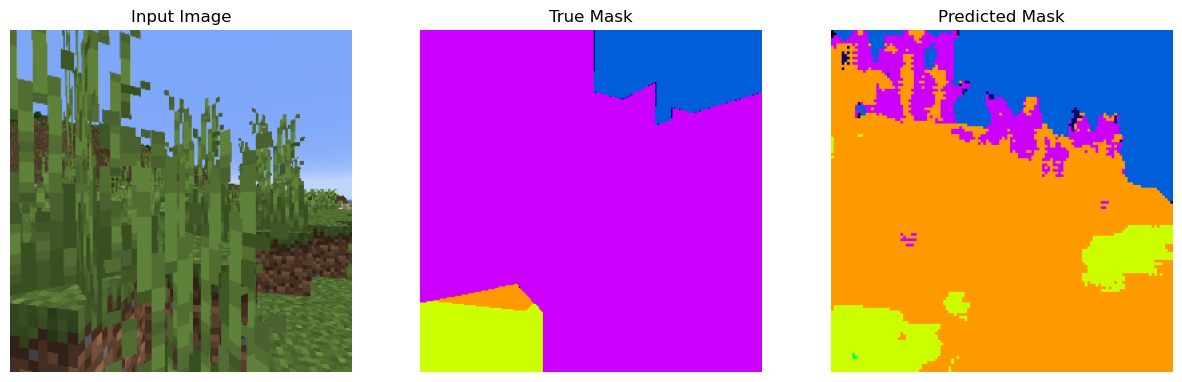

In [19]:
true, pred = show_predictions(test_batches.skip(5), 1)

## Save model

In [28]:
model.save_weights(MODEL_PATH)